# HSE 2024: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 10 days for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [180]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand.

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [181]:
def H(y):
  if y.any():
      return np.mean((y - np.mean(y))**2)
  return 0

In [182]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [183]:
def Q(X, y, j, t):
    x_col = X[:, j]
    y_left = y[x_col <= t]
    y_right = y[x_col > t]
    R_l = len(y_left)
    R_r = len(y_right)
    R = len(y)
    H_left = H(y_left) if R_l > 0 else 0
    H_right = H(y_right) if R_r > 0 else 0
    Q = (R_l / R) * H_left + (R_r / R) * H_right
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [224]:
class Node(object):
    """
    Class for a decision tree node.

    Parameters
    ----------
    right : Node() or None
        Right child
    left : Node() or None
        Left child
    threshold: float

    column: int

    depth: int

    prediction: float
        prediction of the target value in the node
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [225]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
    def best_split(self, X, y):
        n_samples, n_features = X.shape
        best_cost = float('inf')
        best_split_column, best_threshold = None, None
        X_left, y_left, X_right, y_right = None, None, None, None

        for j in range(n_features):
            thresholds = np.unique(X[:, j])
            for t in thresholds:
                cost = Q(X, y, j, t)
                if cost < best_cost:
                    best_cost = cost
                    best_split_column = j
                    best_threshold = t
                    mask_left = X[:, j] <= t
                    mask_right = X[:, j] > t
                    X_left, y_left = X[mask_left], y[mask_left]
                    X_right, y_right = X[mask_right], y[mask_right]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    def is_terminal(self, node, y):
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        if len(y) <= self.min_samples_leaf:
            return True
        return False

    def grow_tree(self, node, X, y):
        if self.is_terminal(node, y):
            node.is_terminal = True
            node.prediction = np.mean(y)
            return

        split_feature, split_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        if X_left is None or len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:
            node.is_terminal = True
            node.prediction = np.mean(y)
            return

        node.column = split_feature
        node.threshold = split_threshold
        node.left = Node()
        node.right = Node()
        node.left.depth = node.depth + 1
        node.right.depth = node.depth + 1

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        self.tree_ = Node()
        self.tree_.depth = 1
        self.tree_.prediction = np.mean(y)

        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        if node.is_terminal:
            return node.prediction
        if x[node.column] <= node.threshold:
            return self.get_prediction(node.left, x)
        else:
            return self.get_prediction(node.right, x)

    def predict(self, X):
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        y_predicted = [self.get_prediction(self.tree_, x) for x in X]
        return np.array(y_predicted)

In [210]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())


### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1 and 2** (root node has **depth 0**) and make the following plot for every case :

- Scatter plot of the traning points for each splitted feature (selected for split feature on the x-axis, target variable on the y-axis). Show the resulting thresholds

After that, fit analogical model from sklearn and visual it

Compare `MAE` on train and test. Have trees overfitted?

In [187]:
df = pd.read_csv('boston_house_prices.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


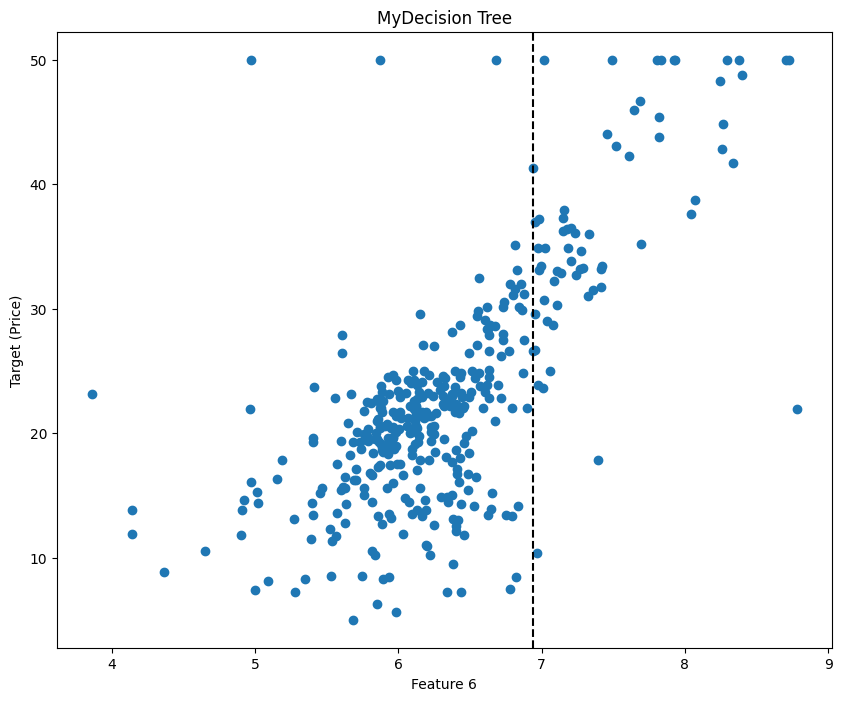

In [246]:
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.tree import DecisionTreeRegressor
y_column = "TARGET"
X_columns = df.columns[df.columns != y_column]
X = np.array(df[X_columns])
y = np.array(df[y_column])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)
model_depth_1 = MyDecisionTreeRegressor(max_depth=2)
model_depth_1.fit(X_train, y_train)
col = model_depth_1.tree_.column
t = model_depth_1.tree_.threshold
plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, col], y_train)
plt.xlabel(f"Feature {col + 1}")
plt.ylabel("Target (Price)")
plt.axvline(t, linestyle='--', color='black')
plt.title("MyDecision Tree")
plt.show()


<Figure size 1000x800 with 0 Axes>

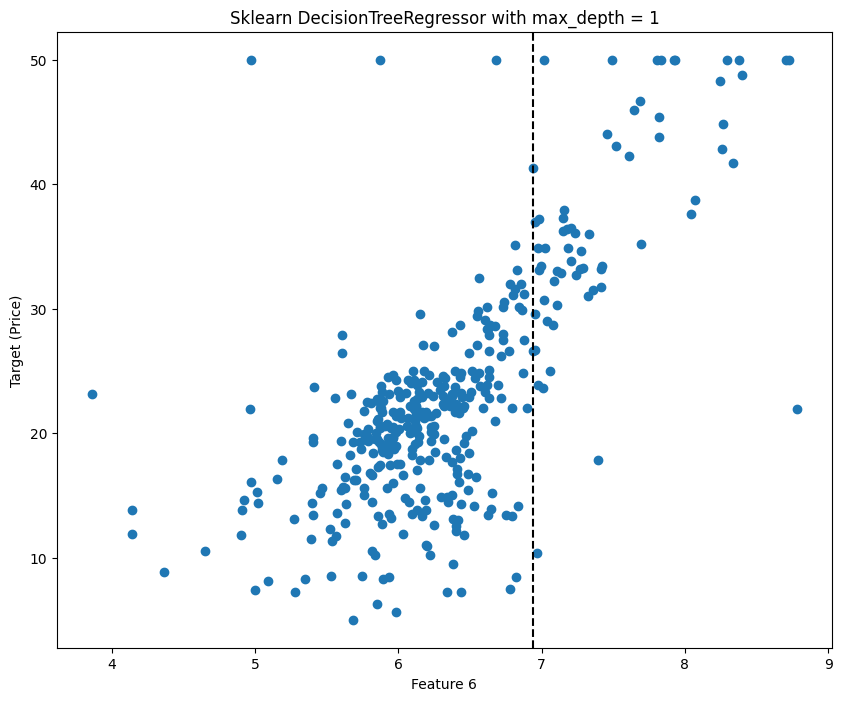

<Figure size 1000x800 with 0 Axes>

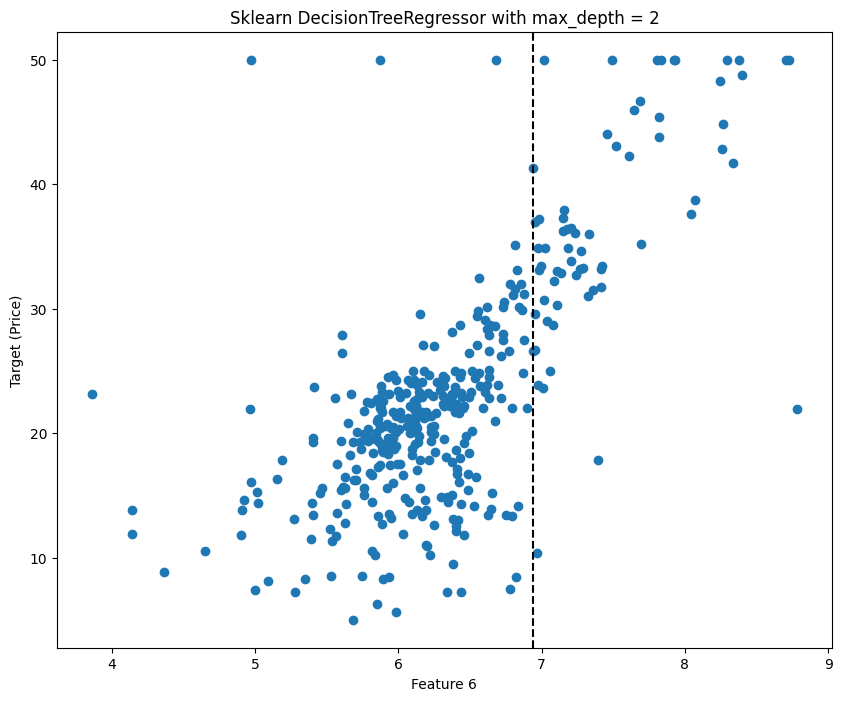

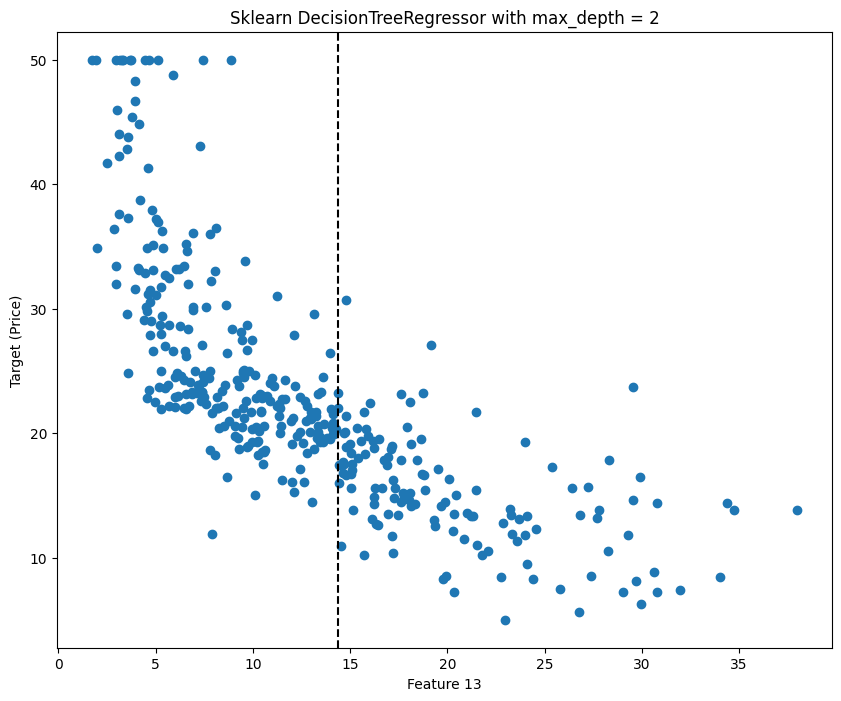

In [253]:
def plot_thres(max_depth):
    plt.figure(figsize=(10, 8))
    model = DecisionTreeRegressor(max_depth = max_depth)
    model.fit(X_train, y_train)
    features = model.tree_.feature
    for i in range(0, features.shape[0]):
      if features[i] == -2:
        break
      plt.figure(figsize=(10, 8))
      plt.scatter(X_train[:, features[i]], y_train)
      plt.axvline(model.tree_.threshold[i], linestyle='--', color='black')
      plt.xlabel(f"Feature {features[i] + 1}")
      plt.ylabel("Target (Price)")
      plt.title(f"Sklearn DecisionTreeRegressor with max_depth = {max_depth}")
      plt.show()
plot_thres(1)
plot_thres(2)

In [254]:
from sklearn.metrics import mean_absolute_error, accuracy_score
model = MyDecisionTreeRegressor()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(mean_absolute_error(y_train, pred_train))
print(mean_absolute_error(y_test, pred_test))

3.5438837649156394
3.6645025895827197


Так как MAE на тестовых данных выше, чем на обучающей выборке, то модель переобучена

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset.
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset.
- Report `MAE` on test dataset and hyperparameters of the best estimator.

In [255]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 3, 4, 5, 6, 7]}
model = GridSearchCV(MyDecisionTreeRegressor(), param_grid=parameters, cv=5)
model.fit(X_train, y_train)
mae = mean_absolute_error(y_test, model.predict(X_test))
print("Best parameters: {}".format(model.best_params_))
print("MAE: {}".format(mae))

Best parameters: {'max_depth': 6, 'min_samples_leaf': 3}
MAE: 2.432954169629976


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [ ]:
from sklearn.utils import resample
def get_bias_variance(estimator, X, y, n_iter):
    predict = np.zeros((X.shape[0], n_iter))
    for i in range(n_iter):
        X_b, y_b = resample(X, y, replace=True, n_samples=X.shape[0])
        oob_indexes = np.setdiff1d(np.arange(X.shape[0]), np.unique(np.where(np.in1d(np.arange(X.shape[0]), X_b))[0]))
        estimator.fit(X_b, y_b)
        predict[oob_indexes, i] = estimator.predict(X[oob_indexes])
    bias2_values = np.zeros(X.shape[0])
    variance_values = np.zeros(X.shape[0])

    for n in range(X.shape[0]):
        bias2_values[n] = (np.mean(predict[n, :]) - y[n]) ** 2
        variance_values[n] = np.var(predict[n, :])
    bias2 = np.mean(bias2_values)
    variance = np.mean(variance_values)

    return bias2, variance

In [ ]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)


(135.47749384057732, 23.316910665188153)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

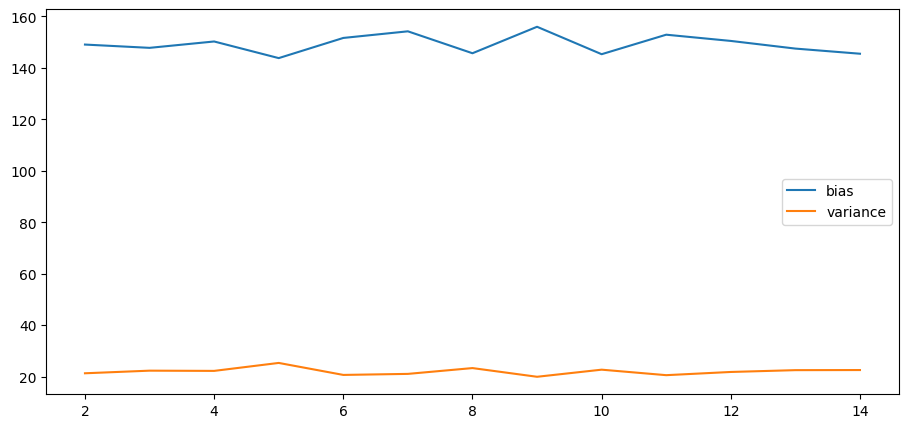

In [ ]:
min_sample_splits = [2,3, 4, 5, 6, 7, 8, 9, 10]
x_points_bias = []
y_point_bias = []
x_variance = []
y_variance = []
for i in range(2, 15):
    bias, variance = get_bias_variance(MyDecisionTreeRegressor(min_samples_split=i), X_train, y_train, 10)
    x_points_bias.append(i)
    y_point_bias.append(bias)
    x_variance.append(i)
    y_variance.append(variance)
plt.plot(x_points_bias, y_point_bias, label="bias")
plt.plot(x_variance, y_variance, label="variance")
plt.legend()
plt.show()

На графике видно, что при увеличении смещения уменьшается дисперсия и наоборот. Это можно объяснить концепцией bias-variance tradeoff - поиском компромисса между смещением и дисперсией(по сути баланса между переобучением и недообучением)

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor
bias, variance = get_bias_variance(BaggingRegressor(estimator), X_train, y_train, 10)
print("Bias: ", bias)
print("Variance: ", variance)

Bias:  136.65259160263855
Variance:  19.826638910165826


Согласно теории бэггинг позводяет снизить дисперсию и не влияет на смещение. Как видно из расчетов выше, после применения бэггинга снизилась дисперсия с 23.316910665188153 до 19.826638910165826, но при этом увеличилось смещение с 135.47749384057732 до 136.65259160263855

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task.

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are more than 10 unique values in a column, use `min_frequency` and/or `max_categories` parameter)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
threshold = 0.5
X = X.dropna(thresh=int(X.shape[0] * (1 - threshold)), axis=1) #отбрасываем столбцы, у которых больше половины пропущенных значений

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object']).columns.tolist()
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

column_transformer = ColumnTransformer(
    transformers=[('cat', categorical_pipeline, categorical_columns), ('num', numerical_pipeline, numerical_columns)],
    remainder='passthrough'
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)
X_train_transformed

array([[ 0.        ,  0.        ,  0.        , ..., -0.30550502,
         0.11542467, -0.00563506],
       [ 0.        ,  0.        ,  0.        , ..., -0.30550502,
         0.11542467, -0.00563506],
       [ 0.        ,  0.        ,  0.        , ...,  1.70160721,
         0.0409845 ,  1.10762503],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.30550502,
         0.11542467, -0.00563506],
       [ 0.        ,  0.        ,  0.        , ..., -0.30550502,
         0.11542467, -1.26639597],
       [ 0.        ,  0.        ,  0.        , ..., -0.905428  ,
         0.70484506, -0.03204645]])

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': make_pipeline(StandardScaler(), SVC(random_state=42)),
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
}

for model_name, model in models.items():
  model.fit(X_train_transformed, y_train)
  print("Model: ",model_name)
  print(f'Cross validation score {cross_val_score(model, X_train_transformed, y_train, scoring="f1", cv=cv).mean():.4f}')
  print(f'Actual test score: {f1_score(y_test, model.predict(X_test_transformed)):.4f}')


Model:  Gradient Boosting
Cross validation score 0.8636
Actual test score: 0.8794
Model:  Random Forest
Cross validation score 0.8735
Actual test score: 0.8777
Model:  Decision Tree
Cross validation score 0.8250
Actual test score: 0.8252
Model:  SVM
Cross validation score 0.8494
Actual test score: 0.8645
Model:  Logistic Regression
Cross validation score 0.8761
Actual test score: 0.8742


Лучший скор на кросс-валидации вышел у Logistic Regression, на тестовой выборке у Gradient Boosting. Переобученных моделей нет. Можно предположить что Decision Tree немного недообучена, поскольку у нее самый низкий скор

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task.

In [ ]:
!pip install catboost --quiet

In [ ]:
from catboost import CatBoostClassifier
cat_boost = CatBoostClassifier(learning_rate=0.01, num_trees=3, depth=5)
cat_boost.fit(X_train_transformed, y_train)
print(f'Test score estimate using Cross-Validation {cross_val_score(cat_boost, X_train_transformed, y_train, scoring="f1", cv=cv).mean():.4f}')
print(f'Actual test score: {f1_score(y_test, cat_boost.predict(X_test_transformed)):.4f}')


0:	learn: 0.6872358	total: 18.9ms	remaining: 37.9ms
1:	learn: 0.6824166	total: 36.9ms	remaining: 18.4ms
2:	learn: 0.6779645	total: 53.4ms	remaining: 0us
0:	learn: 0.6883559	total: 14.7ms	remaining: 29.4ms
1:	learn: 0.6833979	total: 28.3ms	remaining: 14.1ms
2:	learn: 0.6780619	total: 41.9ms	remaining: 0us
0:	learn: 0.6877529	total: 30.1ms	remaining: 60.3ms
1:	learn: 0.6826849	total: 50.6ms	remaining: 25.3ms
2:	learn: 0.6779530	total: 73.7ms	remaining: 0us
0:	learn: 0.6882234	total: 14.1ms	remaining: 28.1ms
1:	learn: 0.6825937	total: 27.8ms	remaining: 13.9ms
2:	learn: 0.6777252	total: 41.5ms	remaining: 0us
0:	learn: 0.6873692	total: 10.2ms	remaining: 20.5ms
1:	learn: 0.6825475	total: 28.4ms	remaining: 14.2ms
2:	learn: 0.6761629	total: 42.4ms	remaining: 0us
0:	learn: 0.6876175	total: 14.2ms	remaining: 28.3ms
1:	learn: 0.6814696	total: 27.6ms	remaining: 13.8ms
2:	learn: 0.6768486	total: 41.5ms	remaining: 0us
Test score estimate using Cross-Validation 0.8443
Actual test score: 0.8496


Результаты лучше, чем у Decision Tree, но хуже чем у остальных моделей

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

In [ ]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

models = {
    "Bagging with decision trees as base estimators": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42
    ),
    "Bagging with gradient boosting": BaggingClassifier(
        estimator=GradientBoostingClassifier(n_estimators=150),
        random_state=42
    ),
    "Voting Classifier": VotingClassifier(
        estimators=[
            ("rf", RandomForestClassifier(random_state=42)),
            ("log_reg", LogisticRegression(random_state=42))
        ]
    ),
    "Stacking with Logistic Regression": StackingClassifier(
        estimators=[
            ("rf", RandomForestClassifier(random_state=42)),
            ("gb", GradientBoostingClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression(random_state=42)
    ),
    "Stacking with Gradient Boosting": StackingClassifier(
        estimators=[
            ("rf", RandomForestClassifier(random_state=42)),
            ("log_reg", LogisticRegression(random_state=42))
        ],
        final_estimator=GradientBoostingClassifier(random_state=42)
    )
}


for name, model in models.items():
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_train_transformed)
    f1 = f1_score(y_train, y_pred)
    print(f"{name}:  train F1 Score = {f1:.4f}")
    print(f"{name}:  test F1 Score = {f1_score(y_test, model.predict(X_test_transformed)):.4f}")

Bagging with decision trees as base estimators:  train F1 Score = 0.9917
Bagging with decision trees as base estimators:  test F1 Score = 0.8479
Bagging with gradient boosting:  train F1 Score = 0.8952
Bagging with gradient boosting:  test F1 Score = 0.8737
Voting Classifier:  train F1 Score = 0.9986
Voting Classifier:  test F1 Score = 0.8760
Stacking with Logistic Regression:  train F1 Score = 0.9986
Stacking with Logistic Regression:  test F1 Score = 0.8845
Stacking with Gradient Boosting:  train F1 Score = 0.9935
Stacking with Gradient Boosting:  test F1 Score = 0.8933


Лучший результат на обучающих данных у Bagging with decision trees as base estimators:  train F1 Score = 0.9917, на тестовых y Stacking with Gradient Boosting:  test F1 Score = 0.8933

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

Лучший test score y Stacking with Gradient Boosting:  test F1 Score = 0.8933

In [ ]:
# YOUR CODE HERE